In [30]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import itertools
import glob
from scipy import stats

0 P0-W0
(373, 504)
(3357, 56)
(3357,)
(1, 3359)
(373, 9)
1 P1-W1
(361, 504)
(3249, 56)
(3249,)
(1, 3251)
(361, 9)
2 P9-W7
(476, 504)
(4284, 56)
(4284,)
(1, 4286)
(476, 9)
3 P14-W0
(461, 504)
(4149, 56)
(4149,)
(1, 4151)
(461, 9)


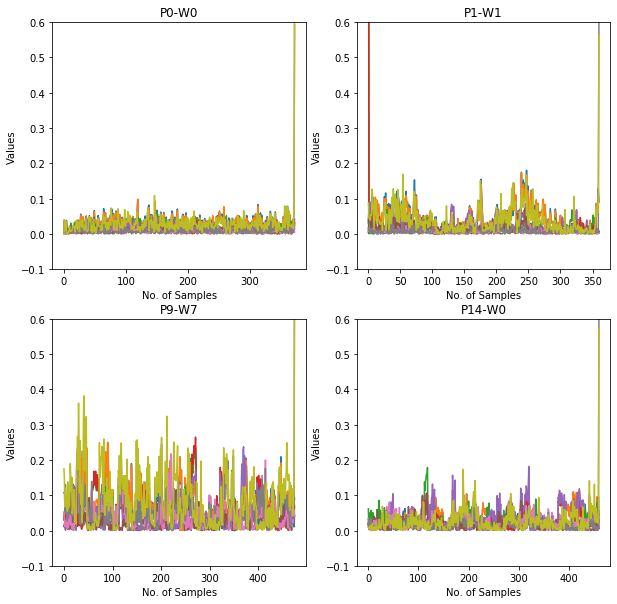

In [62]:
# Train Data = Min/Max/Mean/Std/Median/Entropy

path = r'/home/giang/Lab/Code/Trainsets' # use your path
classes = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

df, x_np, y_np = {}, {}, {}
x_np_all, y_np_all = np.empty((0,9)), np.empty((0))
feature = {}
window_size = 3
temp = np.empty([1,window_size]) 
padding = np.zeros([1,window_size-1])
for i, cls in classes.items():
    print(i, cls)
    all_files = glob.glob(path + "/" + cls + "/*.csv")
    df[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
    x_np[i] = np.transpose(np.array(df[i]))
    print(x_np[i].shape)
    x_np[i] = x_np[i].reshape(-1,56)
    print(x_np[i].shape)
#    x_np[i] = np.amin(x_np[i], axis=1)    #Min Feature
    x_np[i] = np.amax(x_np[i], axis=1)    #Max Feature
#    x_np[i] = np.mean(x_np[i], axis=1)    #Mean Feature
#    x_np[i] = np.std(x_np[i], axis=1)     #Standard Deviation Feature
#    x_np[i] = np.var(x_np[i], axis=1)     # Variance Feature
#    x_np[i] = stats.moment(x_np[i],2, axis=1)   # 2nd order Moment Feature
#    x_np[i] = stats.moment(x_np[i],3, axis=1)   # 3rd order Moment Feature
#    x_np[i] = stats.moment(x_np[i],4, axis=1)   # 4th order Moment Feature
#    x_np[i] = stats.entropy(x_np[i], axis=1)     #Entropy Feature
    print(x_np[i].shape)
    x_np[i]= x_np[i].reshape(1,-1)
    x_np[i]= np.concatenate((x_np[i],padding),axis=1)
    print(x_np[i].shape)
    
    track = np.empty([1,x_np[i].shape[1]-window_size+1])
      
    for j in range(x_np[i].shape[0]):
        for k in range(x_np[i].shape[1]-window_size+1):
            for t in range(window_size):
                temp[0,t] = x_np[i][j,k+t]
            track[j,k] = np.var(temp)
#    print(track.shape)  
    feature[i] = np.array(track)
    feature[i] = feature[i].reshape(-1,9)
    print(feature[i].shape)

           
    y_np[i] = np.ones(len(x_np[i])) * i # Target label

#    x_np_all = np.concatenate((x_np_all, x_np[i]), axis=0)
#    y_np_all = np.concatenate((y_np_all, y_np[i]), axis=0)

#print(x_np_all.shape, y_np_all.shape)

# Visualize data sample
plt.figure(figsize=(10,10))
for i, cls in classes.items():
    plt.subplot(221 + i)
    plt.plot(feature[i])
    plt.ylim(-0.1,0.6)
    plt.xlabel("No. of Samples")
    plt.ylabel("Values")
    plt.title(cls)
plt.show()



# # Visualize data sample
# plt.figure(figsize=(10,10))
# for i, cls in classes.items():
#     plt.subplot(221 + i)
#     plt.plot(x_np[i])
#     plt.ylim(-2.5,1.5)
#     plt.xlabel("No. of Samples")
#     plt.ylabel("Values")
#     plt.title(cls)
# plt.show()


In [3]:
#Divdide and Load Data
data_length = x_np_all.shape[0]
data_id     = np.arange(0, data_length)
np.random.shuffle(data_id)

train_size = 0.5
train_id   = data_id[0:int(train_size*data_length)]
test_id    = data_id[int(train_size*data_length)::]

x_train     = x_np_all[train_id]
y_train     = y_np_all[train_id]
x_test      = x_np_all[test_id]
y_test      = y_np_all[test_id]

train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train, batch_size = 50, shuffle = True,
                                          drop_last=True)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# MLP Model 

#linear1 = torch.nn.Linear(56, 50, bias=True)
linear1 = torch.nn.Linear(9*1, 50, bias=True)
linear2 = torch.nn.Linear(50, 30, bias=True)
linear3 = torch.nn.Linear(30, 4, bias=True)

# He initialization
torch.nn.init.kaiming_uniform_(linear1.weight, mode='fan_in', 
                               nonlinearity='leaky_relu') 
torch.nn.init.kaiming_uniform_(linear2.weight, mode='fan_in', 
                               nonlinearity='leaky_relu')
torch.nn.init.kaiming_uniform_(linear3.weight, mode='fan_in', 
                               nonlinearity='leaky_relu')

# Batch normalization
bn1 = torch.nn.BatchNorm1d(50)
bn2 = torch.nn.BatchNorm1d(30)


# 활성화함수 모듈을 생성
sigmoid = torch.nn.Sigmoid()
#relu = torch.nn.ReLU()
relu = torch.nn.LeakyReLU()

#model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device)

model = torch.nn.Sequential(linear1, bn1, relu, linear2, bn2, relu, linear3).to(device)

In [6]:
#Parameters
training_epochs = 100

criterion = torch.nn.CrossEntropyLoss().to(device)  

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adamax(model.parameters(), lr=0.1)

# 학습
model.train()

for epoch in range(training_epochs):

    avg_cost = 0
    total_batch = len(train_loader)

    for X, T in train_loader:
        X = X.view(-1,9*1).to(device)
        #X = X.view(-1,9*56).to(device)  # MLP
        #X = X.view(-1, 1, 9, 56).to(device)  # CNN
        T = T.to(device)
        #T = T.type(torch.LongTensor)


        optimizer.zero_grad()   # 기존 계산한 경사값 삭제
        output = model(X)       # 순방향 연산
        cost = criterion(output, T)   # 손실함수 설정
        cost.backward()         # 경사값 계산
        optimizer.step()        # 업데이트 1회 수행

        avg_cost += cost / total_batch     # 평균 손실함수값 계산

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    
print('Learning finished')

Epoch: 0001 cost = 0.898672044
Epoch: 0002 cost = 0.435582250
Epoch: 0003 cost = 0.306972861
Epoch: 0004 cost = 0.259563744
Epoch: 0005 cost = 0.225904405
Epoch: 0006 cost = 0.195333779
Epoch: 0007 cost = 0.190477282
Epoch: 0008 cost = 0.163751081
Epoch: 0009 cost = 0.141881689
Epoch: 0010 cost = 0.147725761
Epoch: 0011 cost = 0.137107611
Epoch: 0012 cost = 0.124615334
Epoch: 0013 cost = 0.162304819
Epoch: 0014 cost = 0.118150078
Epoch: 0015 cost = 0.082966298
Epoch: 0016 cost = 0.093532689
Epoch: 0017 cost = 0.090874895
Epoch: 0018 cost = 0.103659615
Epoch: 0019 cost = 0.072769873
Epoch: 0020 cost = 0.103279747
Epoch: 0021 cost = 0.110388733
Epoch: 0022 cost = 0.081076436
Epoch: 0023 cost = 0.071197532
Epoch: 0024 cost = 0.096239477
Epoch: 0025 cost = 0.062946036
Epoch: 0026 cost = 0.078868590
Epoch: 0027 cost = 0.067309879
Epoch: 0028 cost = 0.059063934
Epoch: 0029 cost = 0.061616827
Epoch: 0030 cost = 0.053134553
Epoch: 0031 cost = 0.049138561
Epoch: 0032 cost = 0.051200870
Epoch: 0

In [7]:
# Accuracy With Train Data
with torch.no_grad():
    model.eval()
    
    X_test = torch.Tensor(x_test).to(device)
    T_test = torch.Tensor(y_test).to(device)

    # 테스트셋에 대해 추론 수행
    output = model(X_test.view(-1, 9*1))  # MLP
    #output = model(X_test.view(-1, 1, 9, 56))  # CNN


    # 출력값이 가장 높은 뉴런의 인덱스와 정답을 비교, 맞으면 1, 틀리면 0
    correct_prediction = torch.argmax(output, 1) == T_test

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9844497442245483


Label:  3 (P14-W0)
Prediction:  3


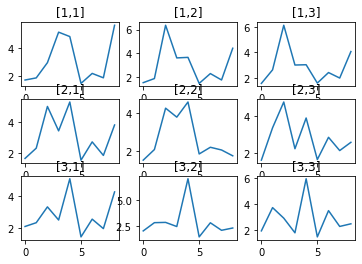

In [8]:
#Test With Train Data
with torch.no_grad():
    # 테스트셋 중에 임의로 하나를 선택
    r = random.randint(0, len(x_test) - 1)    
    X_single_data = torch.Tensor(x_test[r,:]).float().to(device)
    T_single_data = y_test[r]

    print('Label: ', '%d' % T_single_data.item(), '({})'.format(classes[T_single_data.item()]))
    single_output = model(X_single_data.view(-1, 9*1))  # MLP
    #single_output = model(X_single_data.view(-1, 1, 9, 56))  # CNN
    print('Prediction: ', torch.argmax(single_output, 1).item())


# 전체 안테나페어 CSI 플롯팅    
for i in range(9):
  plt.subplot(331 + i)
  plt.plot(x_test[i])
  #plt.xlabel("Subcarrier")
  #plt.ylabel("Amplitude")
  plt.title("[" + str(i//3+1) + "," + str(i%3+1) + "]")

plt.show()

In [9]:
#Load Test Data
path = r'/home/giang/Lab/Code/TestSets' # use your path
classest = {0:'P0-W0',1:'P1-W1'}

dft, x_npt, y_npt = {}, {}, {}
x_npt_all, y_npt_all = np.empty((0, 9)), np.empty((0))

for i, cls in classest.items():
    print(i, cls)
    all_files = glob.glob(path + "/" + cls + "/*.csv")
    dft[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
    x_npt[i] = np.transpose(np.array(dft[i]))
    print(x_npt[i].shape)
    x_npt[i] = x_npt[i].reshape(-1,56)
    print(x_npt[i].shape)
    
#    x_npt[i] = np.amin(x_npt[i], axis=1)    #Min Feature
#    x_npt[i] = np.amax(x_npt[i], axis=1)    #Max Feature
#    x_npt[i] = np.mean(x_npt[i], axis=1)    #Mean Feature
#    x_npt[i] = np.std(x_npt[i], axis=1)     #Standard Deviation Feature
#    x_npt[i] = np.var(x_npt[i], axis=1)     # Variance Feature
#    x_npt[i] = stats.moment(x_npt[i],2, axis=1)   # 2nd order Moment Feature
#    x_npt[i] = stats.moment(x_npt[i],3, axis=1)   # 3rd order Moment Feature
    x_npt[i] = stats.moment(x_npt[i],4, axis=1)   # 4th order Moment Feature
#    x_npt[i] = stats.entropy(x_npt[i], axis=1)     #Entropy Feature

    print(x_npt[i].shape)
    x_npt[i] = x_npt[i].reshape(-1,9)
    print(x_npt[i].shape)
           
    y_npt[i] = np.ones(len(x_npt[i])) * i # Target label

    x_npt_all = np.concatenate((x_npt_all, x_npt[i]), axis=0)
    y_npt_all = np.concatenate((y_npt_all, y_npt[i]), axis=0)

print(x_npt_all.shape, y_npt_all.shape)

test = torch.utils.data.TensorDataset(torch.Tensor(x_npt_all), torch.Tensor(y_npt_all).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test, batch_size = 50, shuffle = True, drop_last =True)

0 P0-W0
(511, 504)
(4599, 56)
(4599,)
(511, 9)
1 P1-W1
(421, 504)
(3789, 56)
(3789,)
(421, 9)
(932, 9) (932,)


Accuracy: 0.005364806856960058
torch.Size([900, 4])
torch.Size([900])
tensor([[  0,   0, 494,   0],
        [  0,   5, 401,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]])


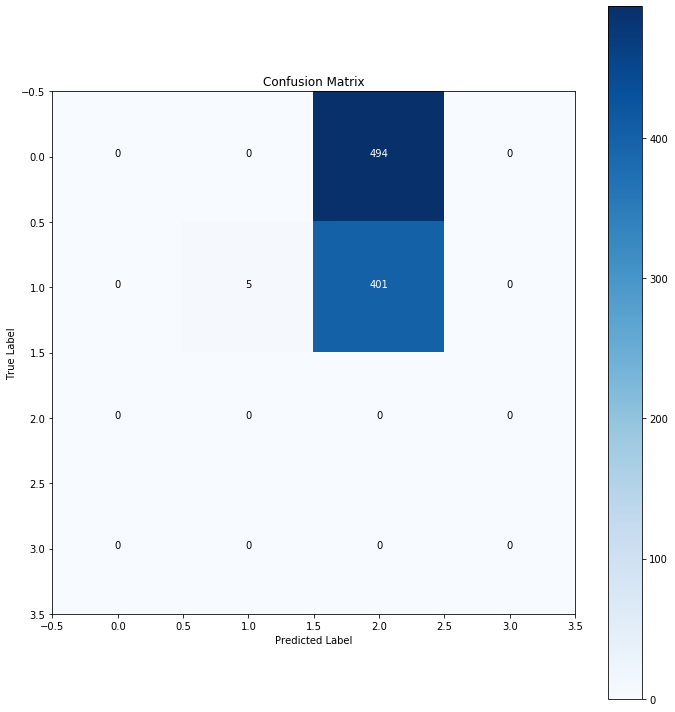

In [10]:
# Test Accuracy
with torch.no_grad():
    model.eval()
    
    Xt_test = torch.Tensor(x_npt_all).to(device)
    Yt_test = torch.Tensor(y_npt_all).to(device)
    # 테스트셋에 대해 추론 수행
   
    #outputtest = model(Xt_test.view(-1, 1, 9, 56))  # CNN
    outputtest = model(Xt_test.view(-1, 9*1))  # MLP

    # 출력값이 가장 높은 뉴런의 인덱스와 정답을 비교, 맞으면 1, 틀리면 0
    correct_prediction = torch.argmax(outputtest, 1) == Yt_test

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

#Confusion Matrix
    all_targetstest = torch.tensor([]).long()
    all_predstest = torch.tensor([])
    
    for X, T in test_loader:
        X = X.view(-1, 9)
        predstest = model(X)
        all_predstest = torch.cat((all_predstest,predstest), dim=0)
        all_targetstest = torch.cat((all_targetstest,T), dim=0)
    print(all_predstest.shape)
    print(all_targetstest.shape)
    
    stackedtest = torch.stack((all_targetstest,all_predstest.argmax(dim=1)),dim=1)
    #print(stackedtest.shape)
    
    cfmattest = torch.zeros(4,4, dtype=torch.int64)
    for p in stackedtest:
        train, pred = p.tolist()
        cfmattest[train, pred] = cfmattest[train, pred] + 1
    print(cfmattest)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cfmattest, interpolation = 'nearest', cmap = 'Blues')
    #tick_marks = np.arange(len(classes.values()))
    #plt.xticks(tick_marks, classes.values(), verticalalignment = 'center')
    #plt.yticks(tick_marks, classes.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.colorbar()
    for i, j in itertools.product(range(cfmattest.shape[0]), range(cfmattest.shape[1])):
            plt.text(j, i, format(cfmattest[i, j], 'd')
                     , horizontalalignment="center"
                     , color="white" if cfmattest[i, j] > (cfmattest.max()/2) else "black")
    plt.tight_layout()